***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.4)** 64D>32D>16D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- Without $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "3" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  3
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/Mod_3_4')

FOLDER CREATED =  ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_4


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 32
    SCap_c_dims = 64


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Skip Connection: For Medium Level
    p_caps_m = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_c.shape[-1]),
                                     s_caps_c.shape[-1]), name="primary_skip_m")(p_caps)
    skip_m = keras.layers.Concatenate(axis=1)([p_caps_m, s_caps_c])

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(skip_m)
    
    ## Skip Connection: For Fine Level
    p_caps_f = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_m.shape[-1]),
                                     s_caps_m.shape[-1]), name="primary_skip_f")(p_caps)
    skip_f = keras.layers.Concatenate(axis=1)([p_caps_f, s_caps_m])

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(skip_f)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 20)          0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 100)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 8)            0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 8)           0           ['prediction_coarse[0][0]']      
 )                                                                                                
          

 tf.math.multiply_8 (TFOpLambda  (None, 100)         0           ['input_yf[0][0]',               
 )                                                                'tf.math.square_4[0][0]']       
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 100)         0           ['tf.math.multiply_9[0][0]',     
 a)                                                               'tf.math.square_5[0][0]']       
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.add[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.reduce_sum_1 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)      

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.4560 - prediction_coarse_accuracy: 0.4781 - prediction_medium_accuracy: 0.2716 - prediction_fine_accuracy: 0.0930
  • Coarse Accuracy = 47.81% | Val_Accuracy = 60.37% | LossWeight = 0.38 
  • Medium Accuracy = 27.16% | Val_Accuracy = 40.04% | LossWeight = 0.47 
  • Fine   Accuracy = 9.30% | Val_Accuracy = 17.16% | LossWeight = 0.15 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.17160, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_4\epoch-best.h5
781/781 [==============================] - 226s 267ms/step - loss: 0.4560 - prediction_coarse_accuracy: 0.4781 - prediction_medium_accuracy: 0.2716 - prediction_fine_accuracy: 0.0930 - val_loss: 0.3700 - val_prediction_coarse_accuracy: 0.6037 - val_prediction_medium_accuracy: 0.4004 - val_prediction_fine_accuracy: 0.1716 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3486 - prediction_coarse_accuracy: 0.6111

781/781 [==============================] - ETA: 0s - loss: 0.1303 - prediction_coarse_accuracy: 0.9163 - prediction_medium_accuracy: 0.8812 - prediction_fine_accuracy: 0.7157
  • Coarse Accuracy = 91.63% | Val_Accuracy = 83.95% | LossWeight = 0.33 
  • Medium Accuracy = 88.12% | Val_Accuracy = 74.50% | LossWeight = 0.42 
  • Fine   Accuracy = 71.57% | Val_Accuracy = 60.28% | LossWeight = 0.26 

Epoch 18: val_prediction_fine_accuracy improved from 0.59610 to 0.60280, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_4\epoch-best.h5
781/781 [==============================] - 197s 252ms/step - loss: 0.1303 - prediction_coarse_accuracy: 0.9163 - prediction_medium_accuracy: 0.8812 - prediction_fine_accuracy: 0.7157 - val_loss: 0.1553 - val_prediction_coarse_accuracy: 0.8395 - val_prediction_medium_accuracy: 0.7450 - val_prediction_fine_accuracy: 0.6028 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1248 - prediction_coarse_accuracy: 0.9249 -

781/781 [==============================] - ETA: 0s - loss: 0.1001 - prediction_coarse_accuracy: 0.9497 - prediction_medium_accuracy: 0.9348 - prediction_fine_accuracy: 0.8387
  • Coarse Accuracy = 94.97% | Val_Accuracy = 85.56% | LossWeight = 0.34 
  • Medium Accuracy = 93.48% | Val_Accuracy = 76.40% | LossWeight = 0.40 
  • Fine   Accuracy = 83.87% | Val_Accuracy = 63.68% | LossWeight = 0.26 

Epoch 36: val_prediction_fine_accuracy did not improve from 0.63850
781/781 [==============================] - 187s 240ms/step - loss: 0.1001 - prediction_coarse_accuracy: 0.9497 - prediction_medium_accuracy: 0.9348 - prediction_fine_accuracy: 0.8387 - val_loss: 0.1457 - val_prediction_coarse_accuracy: 0.8556 - val_prediction_medium_accuracy: 0.7640 - val_prediction_fine_accuracy: 0.6368 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0990 - prediction_coarse_accuracy: 0.9522 - prediction_medium_accuracy: 0.9398 - prediction_fine_accuracy: 0.8441
  • Co

781/781 [==============================] - 193s 247ms/step - loss: 0.0953 - prediction_coarse_accuracy: 0.9543 - prediction_medium_accuracy: 0.9428 - prediction_fine_accuracy: 0.8813 - val_loss: 0.1421 - val_prediction_coarse_accuracy: 0.8623 - val_prediction_medium_accuracy: 0.7773 - val_prediction_fine_accuracy: 0.6485 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0942 - prediction_coarse_accuracy: 0.9555 - prediction_medium_accuracy: 0.9450 - prediction_fine_accuracy: 0.8857
  • Coarse Accuracy = 95.55% | Val_Accuracy = 86.15% | LossWeight = 0.37 
  • Medium Accuracy = 94.50% | Val_Accuracy = 77.81% | LossWeight = 0.41 
  • Fine   Accuracy = 88.57% | Val_Accuracy = 64.97% | LossWeight = 0.22 

Epoch 55: val_prediction_fine_accuracy did not improve from 0.64970
781/781 [==============================] - 190s 244ms/step - loss: 0.0942 - prediction_coarse_accuracy: 0.9555 - prediction_medium_accuracy: 0.9450 - prediction_fine_accuracy: 0.885

781/781 [==============================] - 161s 206ms/step - loss: 0.0924 - prediction_coarse_accuracy: 0.9587 - prediction_medium_accuracy: 0.9486 - prediction_fine_accuracy: 0.9010 - val_loss: 0.1410 - val_prediction_coarse_accuracy: 0.8616 - val_prediction_medium_accuracy: 0.7794 - val_prediction_fine_accuracy: 0.6491 - lr: 3.9499e-05
Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0918 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9476 - prediction_fine_accuracy: 0.9019
  • Coarse Accuracy = 95.84% | Val_Accuracy = 86.36% | LossWeight = 0.37 
  • Medium Accuracy = 94.76% | Val_Accuracy = 77.96% | LossWeight = 0.42 
  • Fine   Accuracy = 90.19% | Val_Accuracy = 64.90% | LossWeight = 0.21 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.65060
781/781 [==============================] - 160s 204ms/step - loss: 0.0918 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9476 - prediction_fine_accuracy: 0.901

Epoch 83/100
781/781 [==============================] - ETA: 0s - loss: 0.0907 - prediction_coarse_accuracy: 0.9598 - prediction_medium_accuracy: 0.9495 - prediction_fine_accuracy: 0.9053
  • Coarse Accuracy = 95.98% | Val_Accuracy = 86.44% | LossWeight = 0.37 
  • Medium Accuracy = 94.95% | Val_Accuracy = 78.14% | LossWeight = 0.42 
  • Fine   Accuracy = 90.53% | Val_Accuracy = 65.09% | LossWeight = 0.21 

Epoch 83: val_prediction_fine_accuracy did not improve from 0.65260
781/781 [==============================] - 158s 203ms/step - loss: 0.0907 - prediction_coarse_accuracy: 0.9598 - prediction_medium_accuracy: 0.9495 - prediction_fine_accuracy: 0.9053 - val_loss: 0.1405 - val_prediction_coarse_accuracy: 0.8644 - val_prediction_medium_accuracy: 0.7814 - val_prediction_fine_accuracy: 0.6509 - lr: 2.3650e-05
Epoch 84/100
781/781 [==============================] - ETA: 0s - loss: 0.0913 - prediction_coarse_accuracy: 0.9575 - prediction_medium_accuracy: 0.9481 - prediction_fine_accuracy: 

781/781 [==============================] - 160s 204ms/step - loss: 0.0918 - prediction_coarse_accuracy: 0.9590 - prediction_medium_accuracy: 0.9505 - prediction_fine_accuracy: 0.9072 - val_loss: 0.1405 - val_prediction_coarse_accuracy: 0.8642 - val_prediction_medium_accuracy: 0.7834 - val_prediction_fine_accuracy: 0.6517 - lr: 1.4905e-05
Epoch 93/100
781/781 [==============================] - ETA: 0s - loss: 0.0914 - prediction_coarse_accuracy: 0.9596 - prediction_medium_accuracy: 0.9491 - prediction_fine_accuracy: 0.9070
  • Coarse Accuracy = 95.96% | Val_Accuracy = 86.44% | LossWeight = 0.37 
  • Medium Accuracy = 94.91% | Val_Accuracy = 78.19% | LossWeight = 0.42 
  • Fine   Accuracy = 90.70% | Val_Accuracy = 65.28% | LossWeight = 0.20 

Epoch 93: val_prediction_fine_accuracy did not improve from 0.65290
781/781 [==============================] - 160s 205ms/step - loss: 0.0914 - prediction_coarse_accuracy: 0.9596 - prediction_medium_accuracy: 0.9491 - prediction_fine_accuracy: 0.907

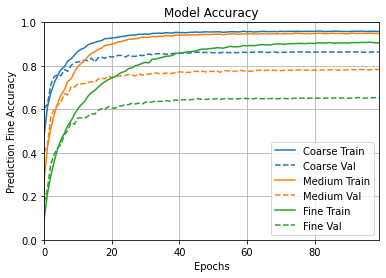

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

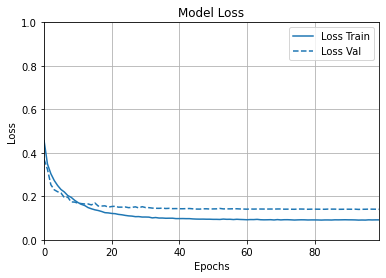

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 14s 35ms/step - loss: 0.1654 - prediction_coarse_loss: 0.1031 - prediction_medium_loss: 0.1681 - prediction_fine_loss: 0.2790 - prediction_coarse_accuracy: 0.8643 - prediction_medium_accuracy: 0.7832 - prediction_fine_accuracy: 0.6528
1. loss ==> 0.16544897854328156
2. prediction_coarse_loss ==> 0.10313277691602707
3. prediction_medium_loss ==> 0.16809655725955963
4. prediction_fine_loss ==> 0.27904996275901794
5. prediction_coarse_accuracy ==> 0.864300012588501
6. prediction_medium_accuracy ==> 0.7832000255584717
7. prediction_fine_accuracy ==> 0.6528000235557556
313/313 [==============================] - 10s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

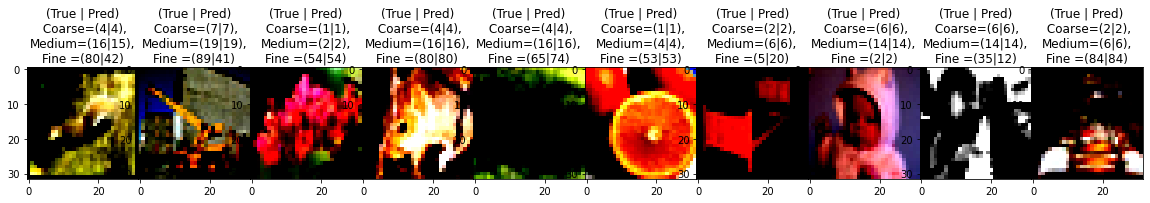

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 741   13   23   33  168    6    8    8]
 [  11 1360   31   25   42   23    6    2]
 [   5   24 1378   24   21    9   14   25]
 [  17   30   31  774  131    2    5   10]
 [ 104   24   56   84 2184   10   16   22]
 [  10   29   26    9   24  874    0   28]
 [  10    6   15   10   32    1  425    1]
 [  12    1   26    5   22   27    0  907]]

  • MEDIUM LEVEL 
[[340  31   0   2   0   3   2   4  14   1   6  17  21  10   3  20  22   0
    2   2]
 [ 32 366   7  10   6   3   1   7   3   0   4   2   4  10   7  24   8   0
    1   5]
 [  0   4 450   6  14   3   0  10   1   1   3   0   1   0   4   3   0   0
    0   0]
 [  1   0   4 415  12  33   9   3   0   2   0   2   0   3   4   3   0   0
    3   6]
 [  2   3  22  10 415  10   0   5   7   0   1   1   2   5   2   8   5   1
    1   0]
 [  0   3   0  40   5 389  19   4   1   6   4   1   1   7  10   2   1   1
    0   6]
 [  1   1   3  11   1  31 425   3   0   1   3   1   2   2   2   3   1   1
    4   4]


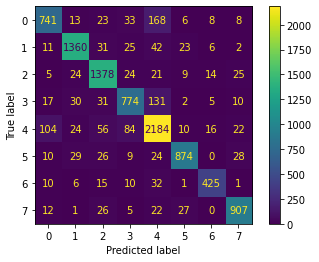

              precision    recall  f1-score   support

           0    0.81429   0.74100   0.77592      1000
           1    0.91459   0.90667   0.91061      1500
           2    0.86885   0.91867   0.89307      1500
           3    0.80290   0.77400   0.78819      1000
           4    0.83232   0.87360   0.85246      2500
           5    0.91807   0.87400   0.89549      1000
           6    0.89662   0.85000   0.87269       500
           7    0.90429   0.90700   0.90564      1000

    accuracy                        0.86430     10000
   macro avg    0.86899   0.85562   0.86176     10000
weighted avg    0.86438   0.86430   0.86382     10000


  • MEDIUM LEVEL 


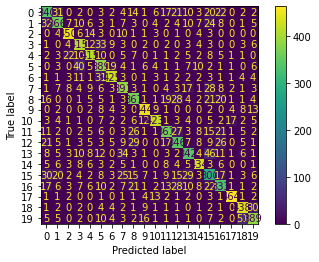

              precision    recall  f1-score   support

           0    0.68687   0.68000   0.68342       500
           1    0.77378   0.73200   0.75231       500
           2    0.88409   0.90000   0.89197       500
           3    0.77138   0.83000   0.79961       500
           4    0.82834   0.83000   0.82917       500
           5    0.70090   0.77800   0.73744       500
           6    0.87449   0.85000   0.86207       500
           7    0.74618   0.78200   0.76367       500
           8    0.73253   0.73400   0.73327       500
           9    0.87402   0.88800   0.88095       500
          10    0.89429   0.84600   0.86948       500
          11    0.77802   0.72200   0.74896       500
          12    0.70612   0.69200   0.69899       500
          13    0.74187   0.68400   0.71176       500
          14    0.86627   0.86800   0.86713       500
          15    0.57034   0.60000   0.58480       500
          16    0.68660   0.66600   0.67614       500
          17    0.93737   0

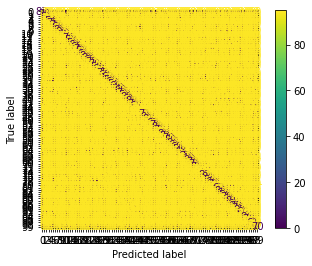

              precision    recall  f1-score   support

           0    0.82178   0.83000   0.82587       100
           1    0.83333   0.75000   0.78947       100
           2    0.50000   0.51000   0.50495       100
           3    0.58228   0.46000   0.51397       100
           4    0.56250   0.54000   0.55102       100
           5    0.65217   0.75000   0.69767       100
           6    0.74038   0.77000   0.75490       100
           7    0.65385   0.68000   0.66667       100
           8    0.80952   0.85000   0.82927       100
           9    0.75926   0.82000   0.78846       100
          10    0.51579   0.49000   0.50256       100
          11    0.44792   0.43000   0.43878       100
          12    0.74510   0.76000   0.75248       100
          13    0.55882   0.57000   0.56436       100
          14    0.56190   0.59000   0.57561       100
          15    0.58879   0.63000   0.60870       100
          16    0.68421   0.65000   0.66667       100
          17    0.80412   0

In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.765065 
Hierarchical Recall = 0.7865 
Hierarchical F1-Score = 0.7734615079365079 
Consistency =  0.8769 
Exact Match =  0.6222


# Training Again

In [22]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1286 - prediction_coarse_accuracy: 0.9195 - prediction_medium_accuracy: 0.8904 - prediction_fine_accuracy: 0.7938
  • Coarse Accuracy = 91.95% | Val_Accuracy = 76.25% | LossWeight = 0.35 
  • Medium Accuracy = 89.04% | Val_Accuracy = 64.82% | LossWeight = 0.43 
  • Fine   Accuracy = 79.38% | Val_Accuracy = 51.18% | LossWeight = 0.21 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.65450
781/781 [==============================] - 139s 178ms/step - loss: 0.1286 - prediction_coarse_accuracy: 0.9195 - prediction_medium_accuracy: 0.8904 - prediction_fine_accuracy: 0.7938 - val_loss: 0.2209 - val_prediction_coarse_accuracy: 0.7625 - val_prediction_medium_accuracy: 0.6482 - val_prediction_fine_accuracy: 0.5118 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1204 - prediction_coarse_accuracy: 0.9267 - prediction_medium_accuracy: 0.8987 - prediction_fine_accuracy: 0.8030


Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1105 - prediction_coarse_accuracy: 0.9385 - prediction_medium_accuracy: 0.9178 - prediction_fine_accuracy: 0.8354
  • Coarse Accuracy = 93.85% | Val_Accuracy = 83.78% | LossWeight = 0.35 
  • Medium Accuracy = 91.78% | Val_Accuracy = 74.47% | LossWeight = 0.43 
  • Fine   Accuracy = 83.54% | Val_Accuracy = 60.85% | LossWeight = 0.22 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.65450
781/781 [==============================] - 139s 178ms/step - loss: 0.1105 - prediction_coarse_accuracy: 0.9385 - prediction_medium_accuracy: 0.9178 - prediction_fine_accuracy: 0.8354 - val_loss: 0.1617 - val_prediction_coarse_accuracy: 0.8378 - val_prediction_medium_accuracy: 0.7447 - val_prediction_fine_accuracy: 0.6085 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.1086 - prediction_coarse_accuracy: 0.9407 - prediction_medium_accuracy: 0.9205 - prediction_fine_accuracy: 0.83

781/781 [==============================] - 140s 179ms/step - loss: 0.0990 - prediction_coarse_accuracy: 0.9502 - prediction_medium_accuracy: 0.9366 - prediction_fine_accuracy: 0.8822 - val_loss: 0.1684 - val_prediction_coarse_accuracy: 0.8272 - val_prediction_medium_accuracy: 0.7380 - val_prediction_fine_accuracy: 0.6011 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.1004 - prediction_coarse_accuracy: 0.9483 - prediction_medium_accuracy: 0.9344 - prediction_fine_accuracy: 0.8803
  • Coarse Accuracy = 94.83% | Val_Accuracy = 85.56% | LossWeight = 0.37 
  • Medium Accuracy = 93.44% | Val_Accuracy = 77.00% | LossWeight = 0.43 
  • Fine   Accuracy = 88.03% | Val_Accuracy = 64.17% | LossWeight = 0.20 

Epoch 20: val_prediction_fine_accuracy did not improve from 0.65450
781/781 [==============================] - 139s 178ms/step - loss: 0.1004 - prediction_coarse_accuracy: 0.9483 - prediction_medium_accuracy: 0.9344 - prediction_fine_accuracy: 0.880

781/781 [==============================] - 143s 184ms/step - loss: 0.0915 - prediction_coarse_accuracy: 0.9588 - prediction_medium_accuracy: 0.9485 - prediction_fine_accuracy: 0.9214 - val_loss: 0.1412 - val_prediction_coarse_accuracy: 0.8679 - val_prediction_medium_accuracy: 0.7803 - val_prediction_fine_accuracy: 0.6532 - lr: 2.3783e-04
Epoch 39/100
781/781 [==============================] - ETA: 0s - loss: 0.0895 - prediction_coarse_accuracy: 0.9604 - prediction_medium_accuracy: 0.9512 - prediction_fine_accuracy: 0.9249
  • Coarse Accuracy = 96.04% | Val_Accuracy = 86.31% | LossWeight = 0.39 
  • Medium Accuracy = 95.12% | Val_Accuracy = 78.16% | LossWeight = 0.43 
  • Fine   Accuracy = 92.49% | Val_Accuracy = 65.53% | LossWeight = 0.17 

Epoch 39: val_prediction_fine_accuracy improved from 0.65450 to 0.65530, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_4\epoch-best.h5
781/781 [==============================] - 144s 184ms/step - loss: 0.0895 - prediction_coarse_accuracy: 

Epoch 48/100
781/781 [==============================] - ETA: 0s - loss: 0.0892 - prediction_coarse_accuracy: 0.9601 - prediction_medium_accuracy: 0.9516 - prediction_fine_accuracy: 0.9286
  • Coarse Accuracy = 96.01% | Val_Accuracy = 86.81% | LossWeight = 0.40 
  • Medium Accuracy = 95.16% | Val_Accuracy = 78.33% | LossWeight = 0.44 
  • Fine   Accuracy = 92.86% | Val_Accuracy = 65.86% | LossWeight = 0.17 

Epoch 48: val_prediction_fine_accuracy did not improve from 0.66210
781/781 [==============================] - 141s 180ms/step - loss: 0.0892 - prediction_coarse_accuracy: 0.9601 - prediction_medium_accuracy: 0.9516 - prediction_fine_accuracy: 0.9286 - val_loss: 0.1390 - val_prediction_coarse_accuracy: 0.8681 - val_prediction_medium_accuracy: 0.7833 - val_prediction_fine_accuracy: 0.6586 - lr: 1.4240e-04
Epoch 49/100
781/781 [==============================] - ETA: 0s - loss: 0.0884 - prediction_coarse_accuracy: 0.9621 - prediction_medium_accuracy: 0.9527 - prediction_fine_accuracy: 

781/781 [==============================] - 143s 183ms/step - loss: 0.0890 - prediction_coarse_accuracy: 0.9610 - prediction_medium_accuracy: 0.9522 - prediction_fine_accuracy: 0.9303 - val_loss: 0.1373 - val_prediction_coarse_accuracy: 0.8716 - val_prediction_medium_accuracy: 0.7881 - val_prediction_fine_accuracy: 0.6586 - lr: 8.9745e-05
Epoch 58/100
781/781 [==============================] - ETA: 0s - loss: 0.0878 - prediction_coarse_accuracy: 0.9620 - prediction_medium_accuracy: 0.9537 - prediction_fine_accuracy: 0.9335
  • Coarse Accuracy = 96.20% | Val_Accuracy = 87.21% | LossWeight = 0.40 
  • Medium Accuracy = 95.37% | Val_Accuracy = 78.82% | LossWeight = 0.44 
  • Fine   Accuracy = 93.35% | Val_Accuracy = 65.89% | LossWeight = 0.16 

Epoch 58: val_prediction_fine_accuracy did not improve from 0.66280
781/781 [==============================] - 141s 180ms/step - loss: 0.0878 - prediction_coarse_accuracy: 0.9620 - prediction_medium_accuracy: 0.9537 - prediction_fine_accuracy: 0.933

781/781 [==============================] - 142s 181ms/step - loss: 0.0883 - prediction_coarse_accuracy: 0.9626 - prediction_medium_accuracy: 0.9540 - prediction_fine_accuracy: 0.9348 - val_loss: 0.1360 - val_prediction_coarse_accuracy: 0.8732 - val_prediction_medium_accuracy: 0.7900 - val_prediction_fine_accuracy: 0.6632 - lr: 3.3866e-05
Epoch 77/100
781/781 [==============================] - ETA: 0s - loss: 0.0877 - prediction_coarse_accuracy: 0.9614 - prediction_medium_accuracy: 0.9529 - prediction_fine_accuracy: 0.9328
  • Coarse Accuracy = 96.14% | Val_Accuracy = 87.19% | LossWeight = 0.40 
  • Medium Accuracy = 95.29% | Val_Accuracy = 78.98% | LossWeight = 0.44 
  • Fine   Accuracy = 93.28% | Val_Accuracy = 66.39% | LossWeight = 0.16 

Epoch 77: val_prediction_fine_accuracy did not improve from 0.66500
781/781 [==============================] - 143s 183ms/step - loss: 0.0877 - prediction_coarse_accuracy: 0.9614 - prediction_medium_accuracy: 0.9529 - prediction_fine_accuracy: 0.932

781/781 [==============================] - 141s 180ms/step - loss: 0.0876 - prediction_coarse_accuracy: 0.9627 - prediction_medium_accuracy: 0.9545 - prediction_fine_accuracy: 0.9368 - val_loss: 0.1363 - val_prediction_coarse_accuracy: 0.8731 - val_prediction_medium_accuracy: 0.7903 - val_prediction_fine_accuracy: 0.6655 - lr: 1.2779e-05
Epoch 96/100
781/781 [==============================] - ETA: 0s - loss: 0.0873 - prediction_coarse_accuracy: 0.9627 - prediction_medium_accuracy: 0.9550 - prediction_fine_accuracy: 0.9380
  • Coarse Accuracy = 96.27% | Val_Accuracy = 87.29% | LossWeight = 0.40 
  • Medium Accuracy = 95.50% | Val_Accuracy = 79.10% | LossWeight = 0.44 
  • Fine   Accuracy = 93.80% | Val_Accuracy = 66.57% | LossWeight = 0.16 

Epoch 96: val_prediction_fine_accuracy did not improve from 0.66630
781/781 [==============================] - 140s 179ms/step - loss: 0.0873 - prediction_coarse_accuracy: 0.9627 - prediction_medium_accuracy: 0.9550 - prediction_fine_accuracy: 0.938

In [23]:
history_dict = history.history

(0.0, 1.0)

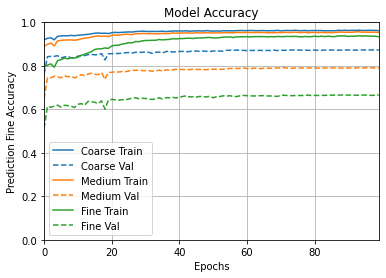

In [24]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

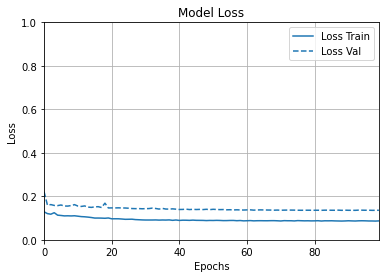

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [26]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 13s 34ms/step - loss: 0.1528 - prediction_coarse_loss: 0.0968 - prediction_medium_loss: 0.1595 - prediction_fine_loss: 0.2752 - prediction_coarse_accuracy: 0.8727 - prediction_medium_accuracy: 0.7906 - prediction_fine_accuracy: 0.6661
1. loss ==> 0.1528153270483017
2. prediction_coarse_loss ==> 0.09677129238843918
3. prediction_medium_loss ==> 0.1594708412885666
4. prediction_fine_loss ==> 0.2752073109149933
5. prediction_coarse_accuracy ==> 0.8726999759674072
6. prediction_medium_accuracy ==> 0.7906000018119812
7. prediction_fine_accuracy ==> 0.666100025177002
313/313 [==============================] - 9s 27ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

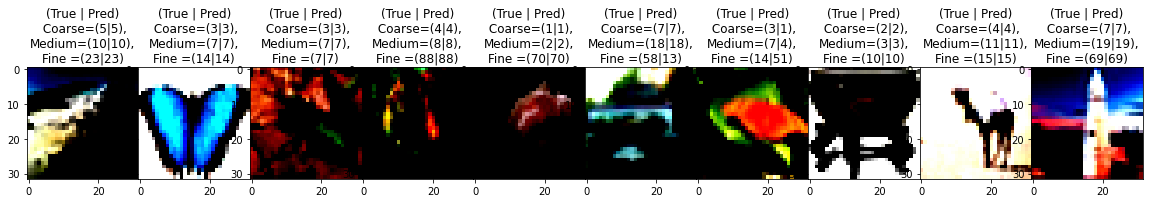

In [27]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 743   11   19   36  166    8    9    8]
 [   9 1375   34   23   39   17    1    2]
 [   5   22 1385   24   27    1    9   27]
 [  17   32   28  792  112    1    5   13]
 [  94   16   43   83 2222   15   12   15]
 [  10   26   24   15   23  874    0   28]
 [  10   10   16   13   28    1  421    1]
 [   7    1   25    4   24   23    1  915]]

  • MEDIUM LEVEL 
[[346  20   0   0   2   5   2   3  12   2   6  13  23  15   4  18  23   0
    2   4]
 [ 31 374   7   8   5   3   1   7   4   0   3   2   6  15   8  17   4   0
    1   4]
 [  1   2 452   5  16   1   1  11   0   1   2   0   1   1   2   2   0   0
    2   0]
 [  0   2   4 410   9  42   8   1   1   0   0   1   2   5   4   3   0   0
    1   7]
 [  0   6  21   9 418  10   1   2   6   0   1   2   3   8   2   6   4   1
    0   0]
 [  2   3   1  36   5 395  18   5   1   1   1   0   0   4   9   2   2   1
    6   8]
 [  0   2   3  16   2  21 431   1   0   1   2   1   1   4   1   2   2   1
    6   3]


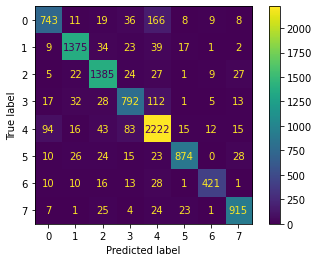

              precision    recall  f1-score   support

           0    0.83017   0.74300   0.78417      1000
           1    0.92096   0.91667   0.91881      1500
           2    0.87992   0.92333   0.90111      1500
           3    0.80000   0.79200   0.79598      1000
           4    0.84135   0.88880   0.86442      2500
           5    0.92979   0.87400   0.90103      1000
           6    0.91921   0.84200   0.87891       500
           7    0.90684   0.91500   0.91090      1000

    accuracy                        0.87270     10000
   macro avg    0.87853   0.86185   0.86942     10000
weighted avg    0.87311   0.87270   0.87225     10000


  • MEDIUM LEVEL 


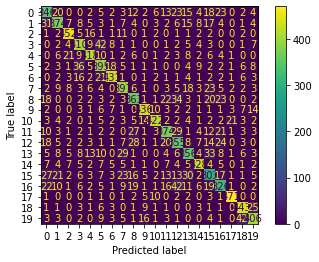

              precision    recall  f1-score   support

           0    0.69339   0.69200   0.69269       500
           1    0.78407   0.74800   0.76561       500
           2    0.87597   0.90400   0.88976       500
           3    0.77947   0.82000   0.79922       500
           4    0.84787   0.83600   0.84189       500
           5    0.72744   0.79000   0.75743       500
           6    0.87780   0.86200   0.86983       500
           7    0.77388   0.79400   0.78381       500
           8    0.73482   0.72600   0.73038       500
           9    0.87903   0.87200   0.87550       500
          10    0.90364   0.84400   0.87280       500
          11    0.76797   0.74800   0.75785       500
          12    0.66855   0.71000   0.68865       500
          13    0.72358   0.71200   0.71774       500
          14    0.87347   0.85600   0.86465       500
          15    0.61963   0.60600   0.61274       500
          16    0.69362   0.65200   0.67216       500
          17    0.93452   0

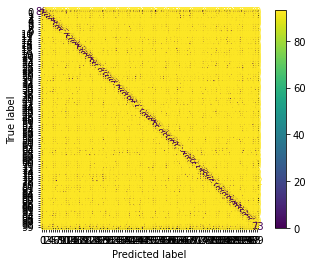

              precision    recall  f1-score   support

           0    0.83333   0.80000   0.81633       100
           1    0.87778   0.79000   0.83158       100
           2    0.56667   0.51000   0.53684       100
           3    0.60714   0.51000   0.55435       100
           4    0.53125   0.51000   0.52041       100
           5    0.66038   0.70000   0.67961       100
           6    0.74257   0.75000   0.74627       100
           7    0.68687   0.68000   0.68342       100
           8    0.81132   0.86000   0.83495       100
           9    0.76852   0.83000   0.79808       100
          10    0.58889   0.53000   0.55789       100
          11    0.45545   0.46000   0.45771       100
          12    0.78571   0.77000   0.77778       100
          13    0.58511   0.55000   0.56701       100
          14    0.57018   0.65000   0.60748       100
          15    0.67000   0.67000   0.67000       100
          16    0.70707   0.70000   0.70352       100
          17    0.87640   0

In [28]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [29]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7739633333333333 
Hierarchical Recall = 0.7930333333333333 
Hierarchical F1-Score = 0.7814361111111111 
Consistency =  0.8885 
Exact Match =  0.6393
